# il faut run la derniere cellule du notebook les boss

In [3]:
import os
current_path = os.getcwd()
print("Current working directory:", current_path)

Current working directory: /


/tmp/ipykernel_18259/948194423.py:17: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='ffill', inplace=True)


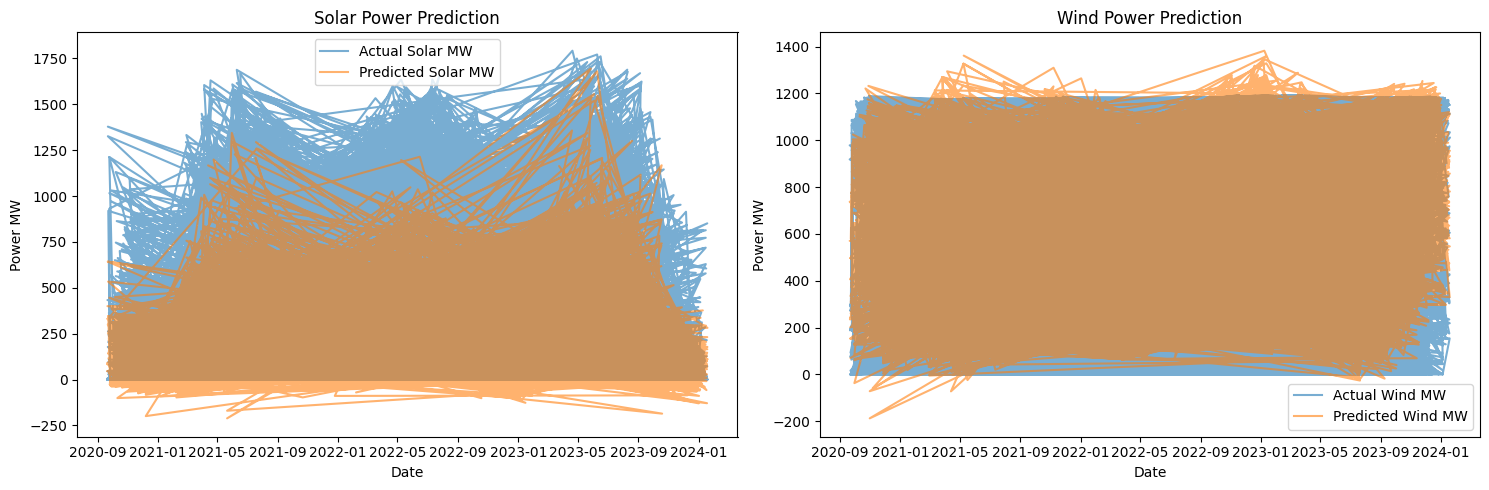

RMSE for Solar Power Prediction: 322.9940651954989
RMSE for Wind Power Prediction: 297.87692567219034


In [1]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Load the dataset
file_path = "./workspace/data/Energy_Data_prepared2.csv"
data = pd.read_csv(file_path)

# Convert datetime column
data['dtm'] = pd.to_datetime(data['dtm'], utc=True)
data.set_index('dtm', inplace=True)

# Handle missing values
data.fillna(method='ffill', inplace=True)

# Define features and target
X = data.drop(columns=['Solar_MW', 'Wind_MW'])
y = data[['Solar_MW', 'Wind_MW']]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the XGBoost models
model_solar = XGBRegressor(objective='reg:squarederror', n_estimators=100)
model_wind = XGBRegressor(objective='reg:squarederror', n_estimators=100)

model_solar.fit(X_train, y_train['Solar_MW'])
model_wind.fit(X_train, y_train['Wind_MW'])

# Make predictions
y_pred_solar = model_solar.predict(X_test)
y_pred_wind = model_wind.predict(X_test)

# Calculate RMSE
rmse_solar = np.sqrt(mean_squared_error(y_test['Solar_MW'], y_pred_solar))
rmse_wind = np.sqrt(mean_squared_error(y_test['Wind_MW'], y_pred_wind))

# Plot results
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(y_test.index, y_test['Solar_MW'], label='Actual Solar MW', alpha=0.6)
plt.plot(y_test.index, y_pred_solar, label='Predicted Solar MW', alpha=0.6)
plt.title('Solar Power Prediction')
plt.xlabel('Date')
plt.ylabel('Power MW')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(y_test.index, y_test['Wind_MW'], label='Actual Wind MW', alpha=0.6)
plt.plot(y_test.index, y_pred_wind, label='Predicted Wind MW', alpha=0.6)
plt.title('Wind Power Prediction')
plt.xlabel('Date')
plt.ylabel('Power MW')
plt.legend()

plt.tight_layout()
plt.show()

# Output RMSE results
print(f"RMSE for Solar Power Prediction: {rmse_solar}")
print(f"RMSE for Wind Power Prediction: {rmse_wind}")

### Feature selection

In [3]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

# Load the dataset
file_path = "./workspace/data/Energy_Data_prepared2.csv"
data = pd.read_csv(file_path)

# Preprocessing
data['dtm'] = pd.to_datetime(data['dtm'], utc=True)
data.set_index('dtm', inplace=True)
data.fillna(method='ffill', inplace=True)
X = data.drop(columns=['Solar_MW', 'Wind_MW'])
y_solar = data['Solar_MW']
y_wind = data['Wind_MW']

# Split the data
X_train, X_test, y_train_solar, y_test_solar, y_train_wind, y_test_wind = train_test_split(X, y_solar, y_wind, test_size=0.2, random_state=42)

# Define pipeline for solar power prediction
solar_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
    ('feature_selection', SelectKBest(score_func=f_regression)),
    ('xgb', XGBRegressor(objective='reg:squarederror'))
])

# Define pipeline for wind power prediction
wind_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
    ('feature_selection', SelectKBest(score_func=f_regression)),
    ('xgb', XGBRegressor(objective='reg:squarederror'))
])

# Setup hyperparameter grid
param_grid = {
    'feature_selection__k': [1, 2, 3, 4, 5],  # Number of features to select
    'xgb__max_depth': [3, 5, 7],
    'xgb__n_estimators': [50, 100, 200],
    'xgb__learning_rate': [0.01, 0.1, 0.2]
}

# Grid search for solar power prediction
grid_search_solar = GridSearchCV(estimator=solar_pipeline, param_grid=param_grid, 
                                 cv=3, n_jobs=-1, verbose=2, scoring='neg_mean_squared_error')
grid_search_solar.fit(X_train, y_train_solar)
best_pipeline_solar = grid_search_solar.best_estimator_

# Grid search for wind power prediction
grid_search_wind = GridSearchCV(estimator=wind_pipeline, param_grid=param_grid, 
                                cv=3, n_jobs=-1, verbose=2, scoring='neg_mean_squared_error')
grid_search_wind.fit(X_train, y_train_wind)
best_pipeline_wind = grid_search_wind.best_estimator_

# Predictions on training data
y_train_pred_solar = best_pipeline_solar.predict(X_train)
y_train_pred_wind = best_pipeline_wind.predict(X_train)

# Predictions on test data
y_pred_solar = best_pipeline_solar.predict(X_test)
y_pred_wind = best_pipeline_wind.predict(X_test)

# Calculate RMSE for training data
rmse_train_solar = np.sqrt(mean_squared_error(y_train_solar, y_train_pred_solar))
rmse_train_wind = np.sqrt(mean_squared_error(y_train_wind, y_train_pred_wind))

# Calculate RMSE for testing data
rmse_test_solar = np.sqrt(mean_squared_error(y_test_solar, y_pred_solar))
rmse_test_wind = np.sqrt(mean_squared_error(y_test_wind, y_pred_wind))

# Output RMSE results for both training and testing data
print("RMSE for Solar Power Prediction (Training):", rmse_train_solar)
print("RMSE for Wind Power Prediction (Training):", rmse_train_wind)
print("RMSE for Solar Power Prediction (Testing):", rmse_test_solar)
print("RMSE for Wind Power Prediction (Testing):", rmse_test_wind)

# Calculate R2 score
r2_solar = r2_score(y_test_solar, y_pred_solar)
r2_wind = r2_score(y_test_wind, y_pred_wind)

# Output R2 score results
print("R2 score for Solar Power Prediction:", r2_solar)
print("R2 score for Wind Power Prediction:", r2_wind)


/tmp/ipykernel_18259/1560068230.py:21: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='ffill', inplace=True)


Fitting 3 folds for each of 135 candidates, totalling 405 fits
[CV] END feature_selection__k=1, xgb__learning_rate=0.01, xgb__max_depth=3, xgb__n_estimators=50; total time=   0.1s
[CV] END feature_selection__k=1, xgb__learning_rate=0.01, xgb__max_depth=3, xgb__n_estimators=50; total time=   0.1s
[CV] END feature_selection__k=1, xgb__learning_rate=0.01, xgb__max_depth=3, xgb__n_estimators=50; total time=   0.1s
[CV] END feature_selection__k=1, xgb__learning_rate=0.01, xgb__max_depth=5, xgb__n_estimators=50; total time=   0.2s
[CV] END feature_selection__k=1, xgb__learning_rate=0.01, xgb__max_depth=5, xgb__n_estimators=50; total time=   0.2s
[CV] END feature_selection__k=1, xgb__learning_rate=0.01, xgb__max_depth=3, xgb__n_estimators=100; total time=   0.3s
[CV] END feature_selection__k=1, xgb__learning_rate=0.01, xgb__max_depth=3, xgb__n_estimators=100; total time=   0.3s
[CV] END feature_selection__k=1, xgb__learning_rate=0.01, xgb__max_depth=5, xgb__n_estimators=50; total time=   0.3s

In [6]:
print(grid_search_wind.best_estimator_)
print(grid_search_solar.best_estimator_)


Pipeline(steps=[('imputer', SimpleImputer()), ('scaler', StandardScaler()),
                ('feature_selection',
                 SelectKBest(k=5,
                             score_func=<function f_regression at 0x7f280b86c400>)),
                ('xgb',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=None, colsample_bynode=None,
                              colsample_bytree=None, device=None,
                              early_stopping_rounds=None,
                              enable_categorical=...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=0.2,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=7, max_leaves=None